Let's first import all the necessary stuff

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from simple_graph_generation import generate_simple_graph, create_sparse_connected_grid, create_delaunay_graph
from target_graph import create_fully_connected_target_graph
from visibility import line_of_sight_visibility, two_hop_visibility

Let's now generate a couple of random graphs and visualize what they look like

In [2]:
num_nodes = 20
num_edges = 100
sample_graph = generate_simple_graph(num_nodes, num_edges)
geometric_graph = nx.random_geometric_graph(num_nodes, 0.25)
grid_graph = nx.grid_2d_graph(5, 4)
sparse_connected_grid = create_sparse_connected_grid(16, 16, node_removal_fraction=0.1, edge_removal_fraction=0.2, target_ratio=1/128, seed=532)
Delaunay_graph = create_delaunay_graph(64, target_ratio = 8/64, seed = 12)

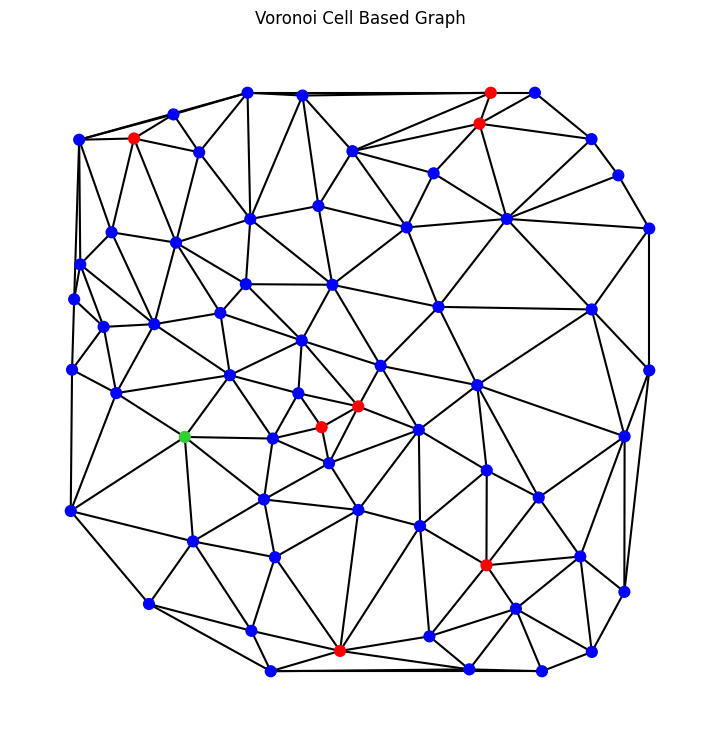

In [3]:
# Get positions from node attributes
pos = nx.get_node_attributes(Delaunay_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in Delaunay_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    else:
        color_map.append("blue")

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    Delaunay_graph,
    pos=pos,
    node_color=color_map, # Apply the color map
    with_labels=False,    # Turn off labels for clarity
    node_size=60,         # Decrease node size
    width=1.5             # Increase edge width
)

plt.title("Voronoi Cell Based Graph")
plt.show()

Let's test the fully connected target graph generation and the visualize the shortest paths

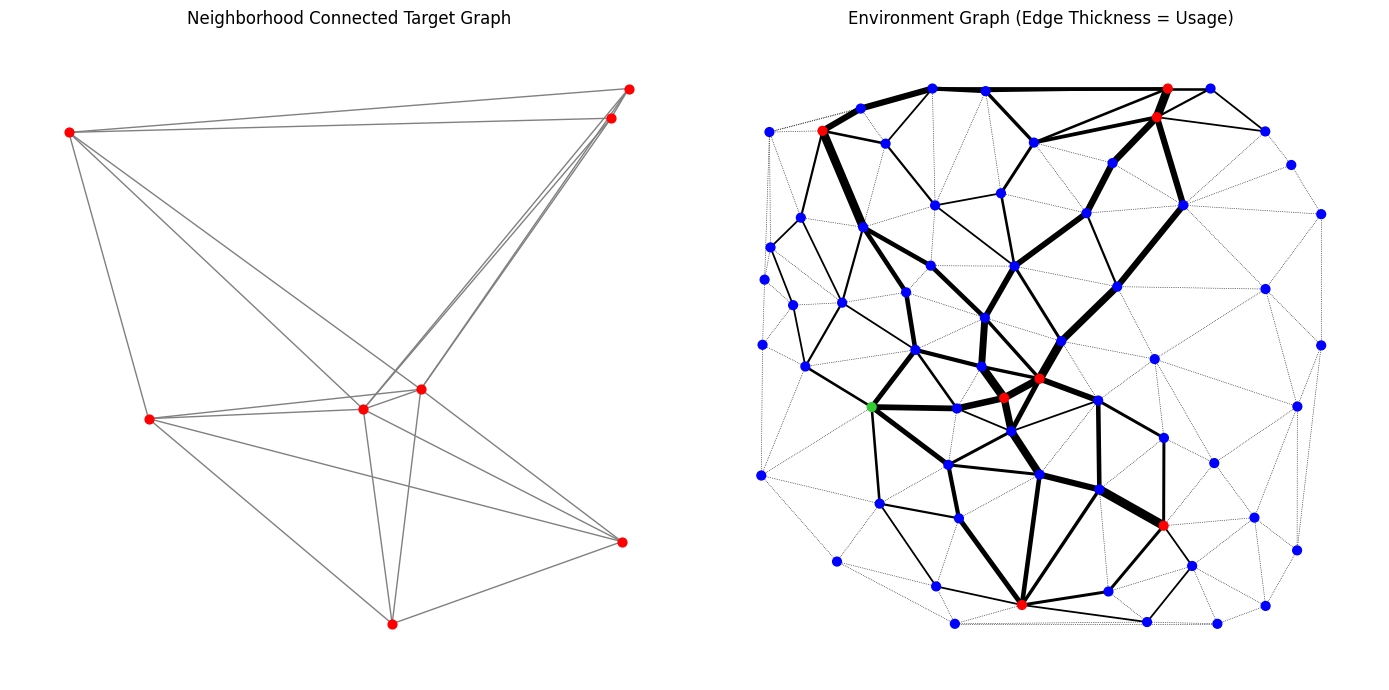

In [4]:
# Create a fully connected graph of target nodes
target_connected_graph = create_fully_connected_target_graph(Delaunay_graph)

# --- 1. Prepare for Plotting ---

# Get positions from node attributes
pos = nx.get_node_attributes(Delaunay_graph, 'pos')

# Create a color map for the sparse graph nodes
color_map_sparse = [
    "limegreen" if data["type"] == "source"
    else "red" if data["type"] == "target_unreached"
    else "blue"
    for node, data in Delaunay_graph.nodes(data=True)
]

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in Delaunay_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 2 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Neighborhood Connected Target Graph")
nx.draw(
    target_connected_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=False,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Environment Graph (Edge Thickness = Usage)")
nx.draw(
    Delaunay_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map_sparse,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Let's now see the visible edge attribute

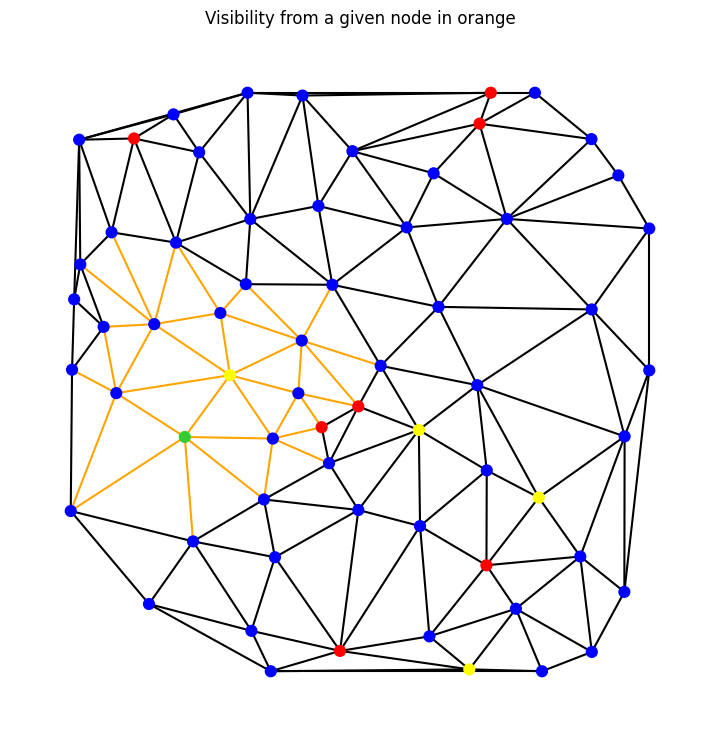

In [5]:
_ = two_hop_visibility(Delaunay_graph, num_extended_nodes=4)

extended_nodes = [node for node in Delaunay_graph.nodes() 
                  if Delaunay_graph.nodes[node].get('has_extended_visibility', True)]
non_extended_nodes = [node for node in Delaunay_graph.nodes() 
                  if Delaunay_graph.nodes[node].get('has_extended_visibility', False)]


source_node = extended_nodes[0] if extended_nodes else non_extended_nodes[0]
visible_edges = Delaunay_graph.nodes[source_node]['visible_edges']

# Get positions from node attributes
pos = nx.get_node_attributes(Delaunay_graph, 'pos')

# Create a list of colors based on node attributes
color_map = []
for node, data in Delaunay_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    elif node in extended_nodes:
        color_map.append("yellow")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in Delaunay_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in visible_edges:
        # Style for visible edges: orange
        edge_color.append('orange')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    Delaunay_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()